<div class="alert alert-success">

### Business Case - Unsupervised Learning: Clustering

**1) Goals Definition**
- Segment customers based on:
  - Purchase frequency
  - Transaction volume
  - Spending patterns
- Identify customer segments and their characteristics
- Propose personalized marketing strategies

**2) Data Preparation (as per Classification Assignment)**
- **Data Loading & Exploration**:
  - Load dataset "Online Retail.xlsx"
  - Initial exploratory analysis (EDA)
- **Data Cleaning**:
  - Handle missing values (imputation/removal)
  - Remove irrelevant columns
- **Correlation Analysis**:
  - Analyze numerical feature correlations
  - Select relevant independent features
- **Feature Engineering**:
  - Feature creation, selection, and transformation
- **Normalization/Standardization**:
  - Scale features for consistent comparison

**3) Model Creation (guided by "Unsupervised Learning - Clustering" Presentation)**
- **Clustering Algorithms Selection**:
  - K-Means (optimal for spherical clusters)
  - DBSCAN (handles arbitrary shapes, noise/outliers)
  - Hierarchical (dendrogram for visualization)
- **Determine Optimal Clusters**:
  - Elbow Method (plot WCSS vs clusters)
  - Silhouette Score (evaluate cohesion and separation)

**4) Model Interpretation**
- **Cluster Profiles**: Define characteristics clearly for each segment
- **Consumption Analysis**: Frequency, total spending, preferred categories
- **Insights Generation**: Actionable recommendations for targeted marketing

**5) Model Implementation**
- **Marketing Strategies**:
  - Targeted promotions
  - Product recommendations
  - Loyalty programs
- **Business Decisions**:
  - Resource allocation
  - Optimize marketing efforts

</div>


In [1]:
# Import libraries
import pandas as pd

# Define path to dataset
file_path = "/Users/oriolventuramiro/Documents/Esade/Term 2/AI II/Assignment 2/Online Retail.xlsx"

# Load dataset
df = pd.read_excel(file_path)

df.info()

# Show shape and preview
print("Dataset shape:", df.shape)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
Dataset shape: (541909, 8)


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [2]:
# Summary statistics
df.describe()

# Missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]


Description      1454
CustomerID     135080
dtype: int64

# 2) Data Preparation
## 2.1 Load Dataset & Initial Exploration

We start by loading the **Online Retail** dataset and exploring its structure and contents. This dataset contains transaction data from an e-commerce retailer and will be the basis for customer segmentation using clustering techniques.

### Dataset Information:
- **Total Rows:** 541,909
- **Total Columns:** 8
- **Key Features:**
  - `InvoiceNo`: Unique invoice identifier.
  - `StockCode`: Product/item identifier.
  - `Description`: Product name.
  - `Quantity`: Number of items purchased.
  - `InvoiceDate`: Timestamp of the transaction.
  - `UnitPrice`: Price per item.
  - `CustomerID`: Unique identifier for each customer.
  - `Country`: Country of residence of the customer.

### Missing Values Detected:
- `Description`: 1,454 missing values
- `CustomerID`: 135,080 missing values

These will be handled in the next step of the data cleaning phase.

## 2.2 Data Cleaning: Invalid Transactions and Missing CustomerID

As part of the data cleaning process, we remove rows that contain invalid or unreliable transaction data:

- Transactions with `Quantity <= 0`: These may correspond to returns or errors.
- Transactions with `UnitPrice <= 0`: These may indicate free products or incorrect price registration.

In addition, since our objective is to perform **customer segmentation**, the `CustomerID` field is essential. Transactions without a customer ID cannot be used to build clusters or extract customer-specific insights. Therefore, we remove all rows with missing `CustomerID` values as well.

Once the dataset is cleaned, we aggregate it at the **customer level** using `groupby("CustomerID")`. This allows us to prepare a customer-level dataset that includes relevant behavioral and transaction-based features, such as:

- Last purchase date
- Total and average quantity purchased
- Average unit price paid
- Number of transactions
- Number of unique products purchased
- Country of the customer

In [3]:
# Create a working copy of the original dataframe
df_cleaned = df.copy()

# Remove rows with missing CustomerID
df_cleaned = df_cleaned.dropna(subset=["CustomerID"])

# Filter out rows with non-positive Quantity or UnitPrice
df_cleaned = df_cleaned[(df_cleaned["Quantity"] > 0) & (df_cleaned["UnitPrice"] > 0)]

# Reset index
df_cleaned.reset_index(drop=True, inplace=True)

# Aggregate directly into df_cleaned (now it will become a customer-level dataset)
df_cleaned = df_cleaned.groupby("CustomerID").agg(
    LastPurchase=("InvoiceDate", "max"),
    TotalQuantity=("Quantity", "sum"),
    AvgQuantity=("Quantity", "mean"),
    AvgUnitPrice=("UnitPrice", "mean"),
    Country=("Country", "first"),
    NumTransactions=("InvoiceNo", "nunique"),
    NumProducts=("StockCode", "nunique")
).reset_index()

# Show result
print("Shape of df_cleaned after aggregation:", df_cleaned.shape)
df_cleaned.head()

Shape of df_cleaned after aggregation: (4338, 8)


CustomerID        LastPurchase  TotalQuantity   AvgQuantity  AvgUnitPrice  \
0     12346.0 2011-01-18 10:01:00          74215  74215.000000      1.040000   
1     12347.0 2011-12-07 15:52:00           2458     13.505495      2.644011   
2     12348.0 2011-09-25 13:13:00           2341     75.516129      5.764839   
3     12349.0 2011-11-21 09:51:00            631      8.643836      8.289041   
4     12350.0 2011-02-02 16:01:00            197     11.588235      3.841176   

          Country  NumTransactions  NumProducts  
0  United Kingdom                1            1  
1         Iceland                7          103  
2         Finland                4           22  
3           Italy                1           73  
4          Norway                1           17

## Creating RFM Features

Now that the dataset has been aggregated at the customer level, we compute the key RFM (Recency, Frequency, Monetary) features required for customer segmentation:

- **Recency**: Calculated as the number of days since the customer's most recent purchase, using a reference date set one day after the latest transaction in the dataset.
- **Frequency**: Measured by the number of unique transactions per customer. We rename the existing `NumTransactions` column to `Frequency` to align with RFM terminology.
- **Monetary**: Represents the total amount spent by each customer across all transactions. It is computed from the original transactional dataset by summing the product of `Quantity × UnitPrice` for each customer.

These three features will be used as inputs for clustering in the next steps.

In [4]:
# Segunda celda: Creación de variables adicionales

# Set reference date for Recency calculation
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Create Recency column in df_cleaned
df_cleaned["Recency"] = (reference_date - df_cleaned["LastPurchase"]).dt.days

# Create TotalPrice column in original df to calculate Monetary
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Monetary: sum of TotalPrice by CustomerID (only for Quantity > 0)
monetary_df = df[df["Quantity"] > 0].groupby("CustomerID")["TotalPrice"].sum().reset_index()
monetary_df.rename(columns={"TotalPrice": "Monetary"}, inplace=True)

# Merge Monetary into df_cleaned
df_cleaned = df_cleaned.merge(monetary_df, on="CustomerID", how="left")

# Rename NumTransactions to Frequency (for RFM)
df_cleaned.rename(columns={"NumTransactions": "Frequency"}, inplace=True)

# Calculate AvgBasketSize
df_cleaned["AvgBasketSize"] = df_cleaned["TotalQuantity"] / df_cleaned["Frequency"]

# Calculate AvgQuantity (New Definition)
df_cleaned["AvgQuantity"] = df_cleaned["TotalQuantity"] / df_cleaned["NumProducts"]

# Calculate ActiveMonths
df["YearMonth"] = df["InvoiceDate"].dt.to_period('M')
active_months = df.groupby("CustomerID")["YearMonth"].nunique().reset_index()
active_months.rename(columns={"YearMonth": "ActiveMonths"}, inplace=True)
df_cleaned = df_cleaned.merge(active_months, on="CustomerID", how="left")

# Calculate AvgPricePerItem
df_cleaned["AvgPricePerItem"] = df_cleaned["Monetary"] / df_cleaned["TotalQuantity"]

# Calculate CustomerLifetime
first_purchase = df.groupby("CustomerID")["InvoiceDate"].min().reset_index()
first_purchase.rename(columns={"InvoiceDate": "FirstPurchase"}, inplace=True)
df_cleaned = df_cleaned.merge(first_purchase, on="CustomerID", how="left")
df_cleaned["CustomerLifetime"] = (df_cleaned["LastPurchase"] - df_cleaned["FirstPurchase"]).dt.days

# Calculate AvgMonetaryPerMonth
df_cleaned["AvgMonetaryPerMonth"] = df_cleaned["Monetary"] / df_cleaned["ActiveMonths"]

# Calculate AvgFrequencyPerMonth
df_cleaned["AvgFrequencyPerMonth"] = df_cleaned["Frequency"] / df_cleaned["ActiveMonths"]

# Drop intermediate columns if necessary (Optional)
df_cleaned.drop(columns=["FirstPurchase"], inplace=True)

# Eliminate 'Country' because its irrelevant
df_cleaned.drop(columns=["Country"], inplace=True)

# Show the result
df_cleaned.head()

CustomerID        LastPurchase  TotalQuantity   AvgQuantity  AvgUnitPrice  \
0     12346.0 2011-01-18 10:01:00          74215  74215.000000      1.040000   
1     12347.0 2011-12-07 15:52:00           2458     23.864078      2.644011   
2     12348.0 2011-09-25 13:13:00           2341    106.409091      5.764839   
3     12349.0 2011-11-21 09:51:00            631      8.643836      8.289041   
4     12350.0 2011-02-02 16:01:00            197     11.588235      3.841176   

   Frequency  NumProducts  Recency  Monetary  AvgBasketSize  ActiveMonths  \
0          1            1      326  77183.60   74215.000000             1   
1          7          103        2   4310.00     351.142857             7   
2          4           22       75   1797.24     585.250000             4   
3          1           73       19   1757.55     631.000000             1   
4          1           17      310    334.40     197.000000             1   

   AvgPricePerItem  CustomerLifetime  AvgMonetaryPerMonth  \
0         1.040000                 0         77183.600000   
1         1.753458               365           615.714286   
2         0.767723               282           449.310000   
3         2.785341                 0          1757.550000   
4         1.697462                 0           334.400000   

   AvgFrequencyPerMonth  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0

## 2.3 Analyze Distributions and Check for Outliers

Before applying clustering algorithms, we analyze the distributions of the RFM features:

- **Histogram**: Helps visualize skewness in the data.
- **Boxplot**: Helps identify extreme outliers.

Highly skewed distributions or extreme values can distort distance-based clustering (like K-Means), so we may apply log-transformation or cap outliers if needed.

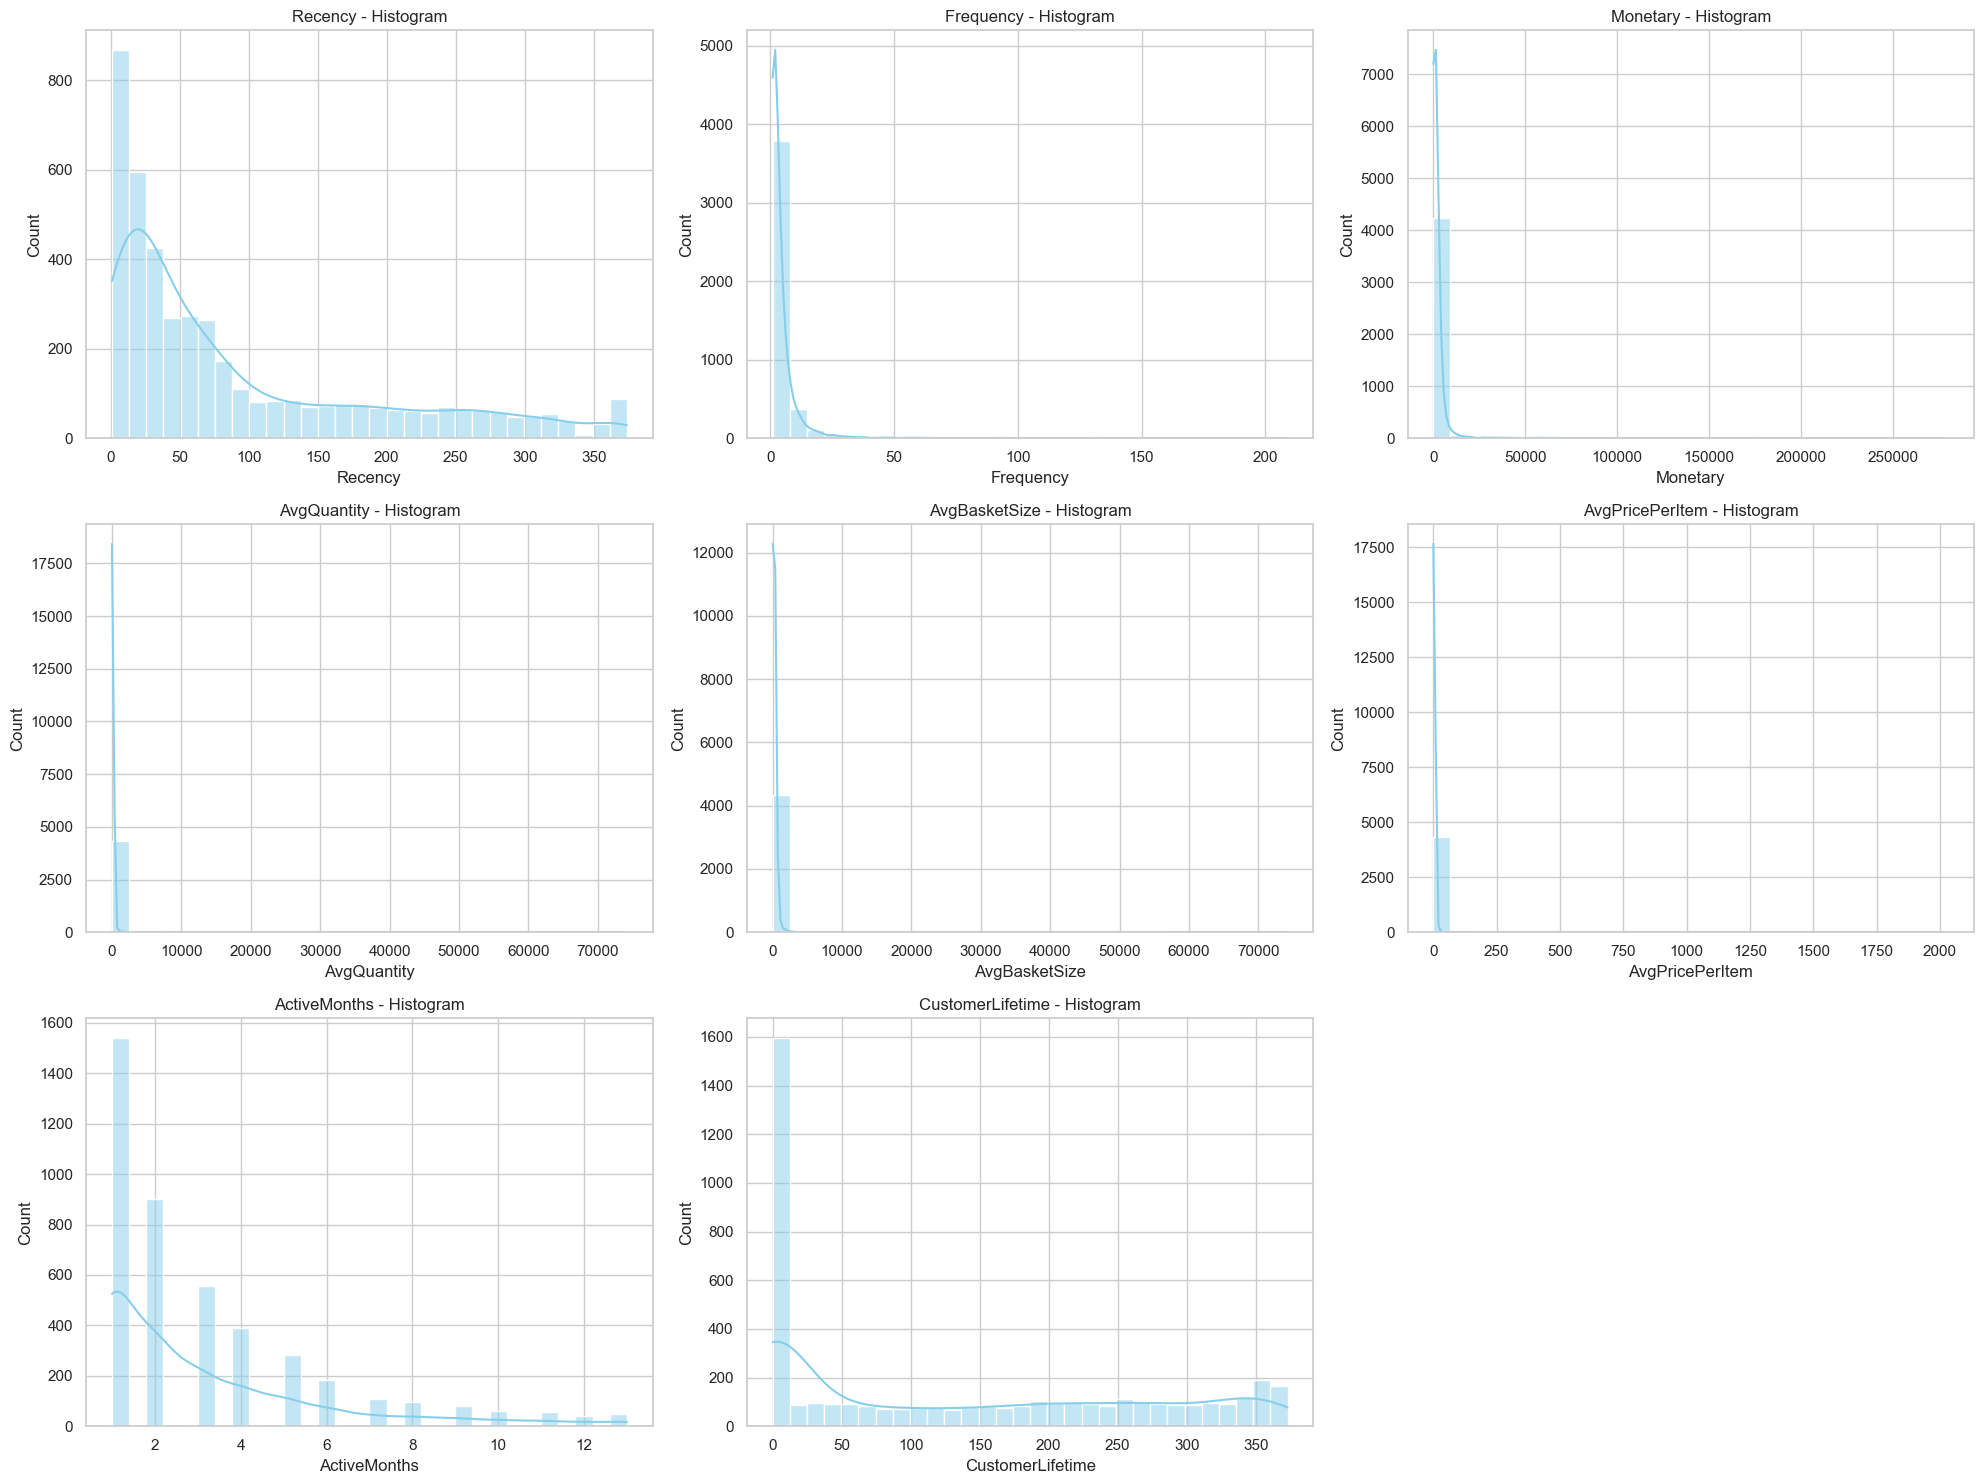

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

clustering_features = [
    "Recency", "Frequency", "Monetary", "AvgQuantity", 
    "AvgBasketSize", "AvgPricePerItem", 
    "ActiveMonths", "CustomerLifetime"
]

# Plot histograms for all clustering features
plt.figure(figsize=(20, 15))
for i, col in enumerate(clustering_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_cleaned[col], kde=True, bins=30, color="skyblue")
    plt.title(f"{col} - Histogram")
    plt.xlabel(col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Analyzing Distributions and Checking for Outliers

In this step, we will assess the skewness of the RFM features to identify whether transformations are needed to reduce skewness and improve cluster separation. Highly skewed features can negatively affect distance-based clustering algorithms.

#### Why Check for Skewness?
- **Normal distributions** are preferred for clustering algorithms.
- High skewness can distort clustering results, especially for distance-based methods.
- Applying transformations like `logarithm` can help mitigate skewness.

#### Steps to Follow:
1. **Visualize distributions using histograms and bar plots.**
2. **Calculate skewness for each RFM feature.**
3. **Apply logarithmic transformation if skewness is high.**

In [6]:
from scipy.stats import skew

# Variables we will use for clustering (without removing the others from the original dataset)
clustering_features = [
    "Recency", "Frequency", "Monetary", "AvgQuantity", 
    "AvgBasketSize", "AvgPricePerItem", 
    "ActiveMonths", "CustomerLifetime"
]

# Calculate skewness for all selected columns
skewness_values = {}

for col in clustering_features:
    skewness_values[col] = skew(df_cleaned[col])

# Display skewness results
print("Skewness of Clustering Features:")
for col, skew_value in skewness_values.items():
    print(f"{col}: {skew_value:.2f}")

Skewness of Clustering Features:
Recency: 1.25
Frequency: 12.06
Monetary: 19.32
AvgQuantity: 55.13
AvgBasketSize: 47.97
AvgPricePerItem: 54.23
ActiveMonths: 1.67
CustomerLifetime: 0.43


## 2.4 Log Transformation of Skewed Features

To reduce the impact of extreme values and highly skewed distributions, we apply a log transformation to the `Recency` `Frequency` and `Monetary` features. This transformation helps clustering algorithms (especially distance-based ones like KMeans) perform better by smoothing large numerical ranges.

We use `np.log1p()`, which computes `log(1 + x)` and safely handles zero values.

In [7]:
import numpy as np

# Variables that need logarithmic transformation (skewness > 1.0)
log_transform_features = [
    "Recency", "Frequency", "Monetary", "AvgQuantity", 
    "AvgBasketSize", "AvgPricePerItem", "ActiveMonths"
]

# Apply log1p transformation to the selected variables
for feature in log_transform_features:
    df_cleaned[f"{feature}_log"] = np.log1p(df_cleaned[feature])

# Quick visualization of some of the transformed variables
df_cleaned[[col for col in df_cleaned.columns if "_log" in col]].head()

Recency_log  Frequency_log  Monetary_log  AvgQuantity_log  \
0     5.789960       0.693147     11.253955        11.214735   
1     1.098612       2.079442      8.368925         3.213424   
2     4.330733       1.609438      7.494564         4.676645   
3     2.995732       0.693147      7.472245         2.266319   
4     5.739793       0.693147      5.815324         2.532763   

   AvgBasketSize_log  AvgPricePerItem_log  ActiveMonths_log  
0          11.214735             0.712950          0.693147  
1           5.864037             1.012858          2.079442  
2           6.373746             0.569692          1.609438  
3           6.448889             1.331136          0.693147  
4           5.288267             0.992311          0.693147

After applying the log transformation to the `Recency`, `Frequency`, and `Monetary` features, we visualize their distributions to ensure the transformation has improved skewness and made the data more suitable for clustering.

### Objective
- Visualize the distributions of the log-transformed RFM features to evaluate the impact of the log transformation.

### Approach
- Plot histograms with Kernel Density Estimation (KDE) for each transformed feature.
- Compare the distributions before and after the log transformation.
- Expect more symmetric and normally distributed data, improving clustering performance.

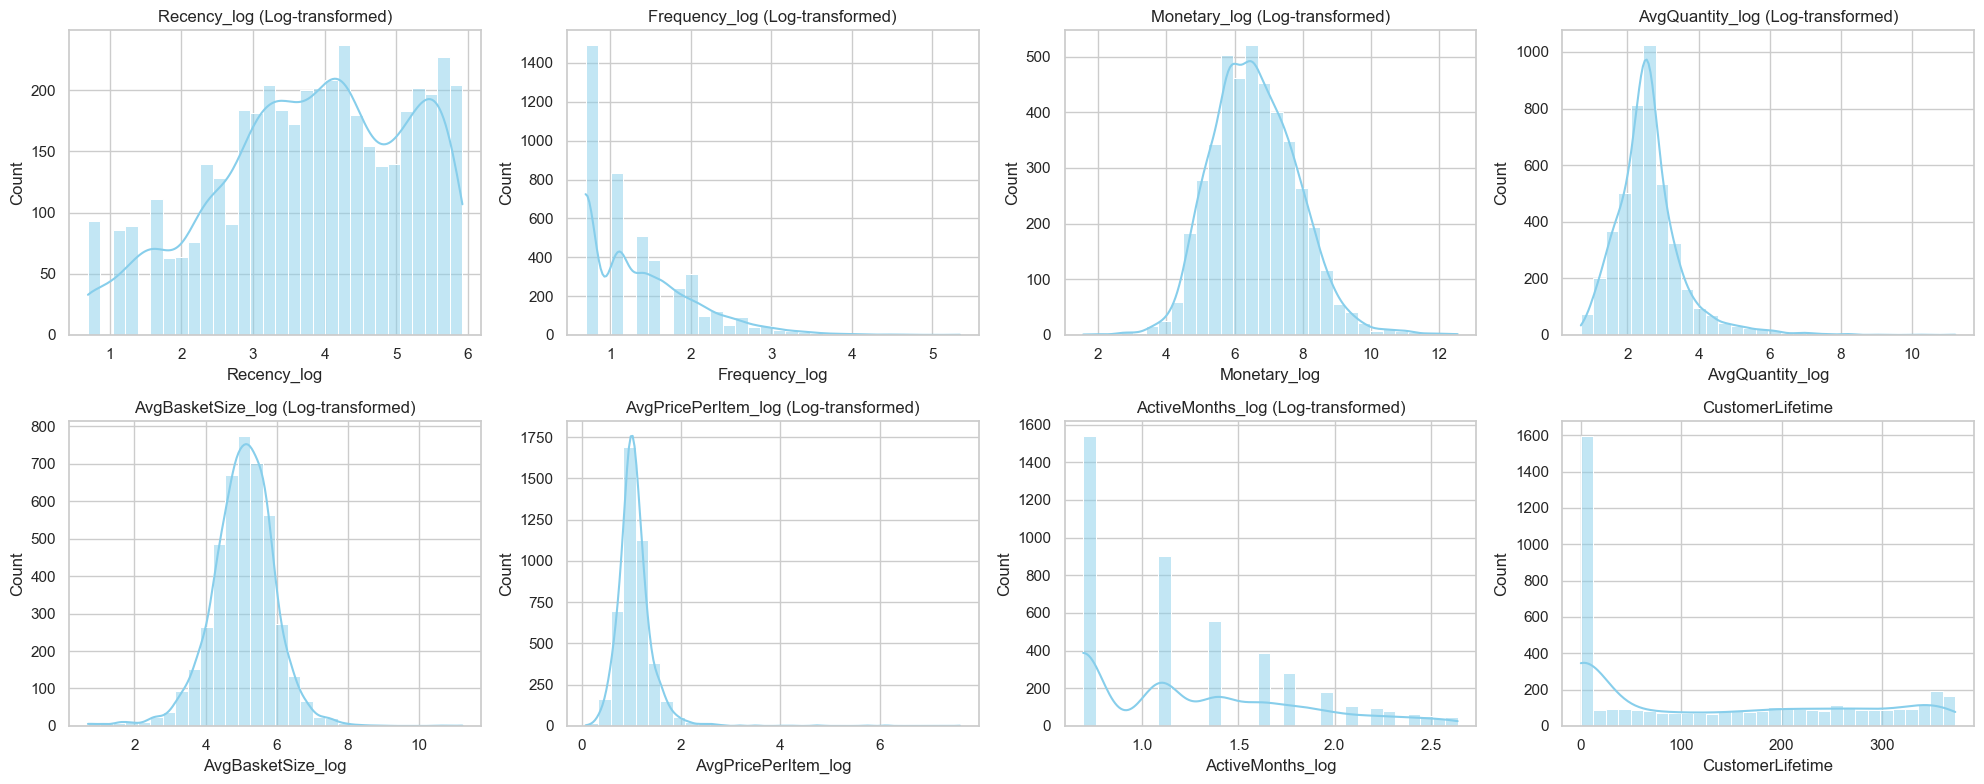

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Log-transformed variables to visualize (including CustomerLifetime without transformation)
log_transformed_features = [
    "Recency_log", "Frequency_log", "Monetary_log", "AvgQuantity_log", 
    "AvgBasketSize_log", "AvgPricePerItem_log", 
    "ActiveMonths_log", "CustomerLifetime"  # Included without log transformation
]

# Plot histograms of log-transformed features
num_features = len(log_transformed_features)
num_cols = 4
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

plt.figure(figsize=(20, num_rows * 4))

for i, feature in enumerate(log_transformed_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df_cleaned[feature], kde=True, bins=30, color="skyblue")
    plt.title(f"{feature} (Log-transformed)" if "_log" in feature else f"{feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [9]:
# List of all relevant log-transformed columns (excluding unused variables)
log_transformed_columns = [
    "Recency_log", "Frequency_log", "Monetary_log", "AvgQuantity_log", 
    "AvgBasketSize_log", "AvgPricePerItem_log", 
    "ActiveMonths_log", "CustomerLifetime"  # Included without log transformation
]

# Calculate skewness for each log-transformed variable
skewness_log = df_cleaned[log_transformed_columns].skew().reset_index()
skewness_log.columns = ["Feature", "Skewness"]

# Display the results
print("Skewness of Relevant Log-Transformed Features:")
print(skewness_log)

Skewness of Relevant Log-Transformed Features:
               Feature  Skewness
0          Recency_log -0.379169
1        Frequency_log  1.208652
2         Monetary_log  0.393553
3      AvgQuantity_log  1.746932
4    AvgBasketSize_log -0.362832
5  AvgPricePerItem_log  4.470576
6     ActiveMonths_log  0.682527
7     CustomerLifetime  0.435039



## 2.5 Normalize the Features

Since clustering algorithms are distance-based, we normalize the selected features using `StandardScaler`. This ensures that each feature contributes equally to the distance calculations.

We apply the scaler to the three RFM features:
- `Recency_log`
- `Frequency_log`
- `Monetary_log`

In [10]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select only the relevant log-transformed variables for clustering
features_to_scale = [
    "Recency_log", "Frequency_log", "Monetary_log", "AvgQuantity_log", 
    "AvgBasketSize_log", "AvgPricePerItem_log", 
    "ActiveMonths_log", "CustomerLifetime"  # Included without log transformation
]

# Create a new DataFrame with the selected columns to be scaled
X = df_cleaned[features_to_scale]

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame and add CustomerID
X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_scale)
X_scaled_df.insert(0, "CustomerID", df_cleaned["CustomerID"].values)

# Display the final scaled dataset
X_scaled_df.head()

CustomerID  Recency_log  Frequency_log  Monetary_log  AvgQuantity_log  \
0     12346.0     1.461993      -0.955214      3.706225         9.105480   
1     12347.0    -2.038734       1.074425      1.411843         0.645384   
2     12348.0     0.373104       0.386304      0.716489         2.192504   
3     12349.0    -0.623086      -0.955214      0.698739        -0.356027   
4     12350.0     1.424558      -0.955214     -0.618962        -0.074306   

   AvgBasketSize_log  AvgPricePerItem_log  ActiveMonths_log  CustomerLifetime  
0           6.828298            -0.935731         -1.024971         -0.996568  
1           0.905794            -0.160235          1.501531          1.751535  
2           1.469974            -1.306163          0.644956          1.126624  
3           1.553147             0.662763         -1.024971         -0.996568  
4           0.268494            -0.213363         -1.024971         -0.996568

To eliminate extreme values that could negatively affect the clustering process, we apply an outlier removal technique using the **Z-score method**. This approach allows us to filter out data points that deviate significantly from the mean. 

#### Code Explanation:

1. **Calculate Z-scores:** 
   We calculate the Z-scores for all scaled features (`Recency_log`, `Frequency_log`, `Monetary_log`) using the `StandardScaler`. This transformation ensures all features have a mean of 0 and a standard deviation of 1.

2. **Set Threshold:** 
   We set a threshold of 3 (`z_thresh = 3`), which means any data point with a Z-score greater than 3 or less than -3 will be considered an outlier.

3. **Apply Filter:** 
   We filter the dataset to keep only rows where all feature values are within the Z-score threshold.

4. **Check Skewness:** 
   After filtering, we recalculate skewness to confirm if the outlier removal has improved the distribution of our features.

In [11]:
from scipy import stats
import numpy as np

# Z-score threshold (3 is a commonly used value)
z_thresh = 3

# List of relevant log-transformed variables to filter
features_to_filter = [
    "Recency_log", "Frequency_log", "Monetary_log", "AvgQuantity_log", 
    "AvgBasketSize_log", "AvgPricePerItem_log", 
    "ActiveMonths_log", "CustomerLifetime"  # Included without log transformation
]

# Calculate the Z-score for each value in the relevant columns
z_scores = np.abs(stats.zscore(X_scaled_df[features_to_filter]))

# Create a mask to filter rows that have a Z-score below the threshold in all columns
mask = (z_scores < z_thresh).all(axis=1)

# Filter the original DataFrame to remove outliers
X_scaled_filtered = X_scaled_df[mask]

# Display the result
print("Shape before removing outliers:", X_scaled_df.shape)
print("Shape after removing outliers:", X_scaled_filtered.shape)
X_scaled_filtered.head()

Shape before removing outliers: (4338, 9)
Shape after removing outliers: (4165, 9)


CustomerID  Recency_log  Frequency_log  Monetary_log  AvgQuantity_log  \
1     12347.0    -2.038734       1.074425      1.411843         0.645384   
2     12348.0     0.373104       0.386304      0.716489         2.192504   
3     12349.0    -0.623086      -0.955214      0.698739        -0.356027   
4     12350.0     1.424558      -0.955214     -0.618962        -0.074306   
5     12352.0    -0.164029       1.246868      0.980753        -0.308759   

   AvgBasketSize_log  AvgPricePerItem_log  ActiveMonths_log  CustomerLifetime  
1           0.905794            -0.160235          1.501531          1.751535  
2           1.469974            -1.306163          0.644956          1.126624  
3           1.553147             0.662763         -1.024971         -0.996568  
4           0.268494            -0.213363         -1.024971         -0.996568  
5          -0.914479             1.710040          0.644956          0.960985

In [12]:
# List of relevant log-transformed columns being used (and CustomerLifetime without log transformation)
filtered_log_features = [
    "Recency_log", "Frequency_log", "Monetary_log", "AvgQuantity_log", 
    "AvgBasketSize_log", "AvgPricePerItem_log", 
    "ActiveMonths_log", "CustomerLifetime"
]

# Calculate skewness for each of the filtered variables
skewness_log_filtered = X_scaled_filtered[filtered_log_features].skew().reset_index()
skewness_log_filtered.columns = ["Feature", "Skewness"]

# Display the results
print("Skewness of Log-Transformed and Filtered Features:")
print(skewness_log_filtered)

Skewness of Log-Transformed and Filtered Features:
               Feature  Skewness
0          Recency_log -0.371163
1        Frequency_log  0.877862
2         Monetary_log  0.177912
3      AvgQuantity_log  0.638396
4    AvgBasketSize_log -0.217466
5  AvgPricePerItem_log  0.617597
6     ActiveMonths_log  0.648924
7     CustomerLifetime  0.446465


In [13]:
from sklearn.decomposition import PCA

# Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_filtered.drop("CustomerID", axis=1))

# Display the explained variance ratio
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance by 2 components: {explained_variance:.2%}")

Explained variance by 2 components: 73.64%


Explained variance by 2 components: 73.64%


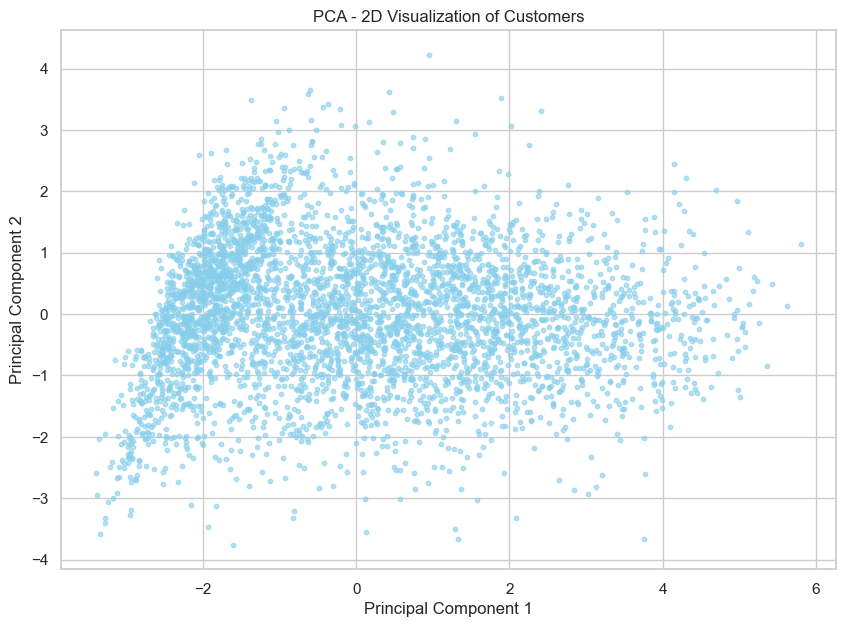

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_filtered.drop("CustomerID", axis=1))

# Show explained variance ratio
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance by 2 components: {explained_variance:.2%}")

# Plot the PCA result in 2D
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6, color="skyblue")
plt.title("PCA - 2D Visualization of Customers")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# 3) Model Creation 
## 3.1 Determine optimal Clusters

## Elbow Method for Optimal Number of Clusters

The **Elbow Method** is a technique used to determine the optimal number of clusters (`k`) in a clustering algorithm. This method is based on measuring the **Inertia**, which is the sum of squared distances between each data point and the centroid of its assigned cluster.

The process involves:
1. **Applying the K-Means algorithm** to different numbers of clusters (`k`) and calculating the inertia for each case.
2. **Plotting the inertia** against the number of clusters.
3. Identifying the "elbow" point (where the decrease in inertia becomes less pronounced).

Generally, the optimal number of clusters is found where the graph shows a sharp bend, indicating that adding more clusters does not significantly improve compactness. This number will be used as a basis for evaluating model performance with the Silhouette Score.

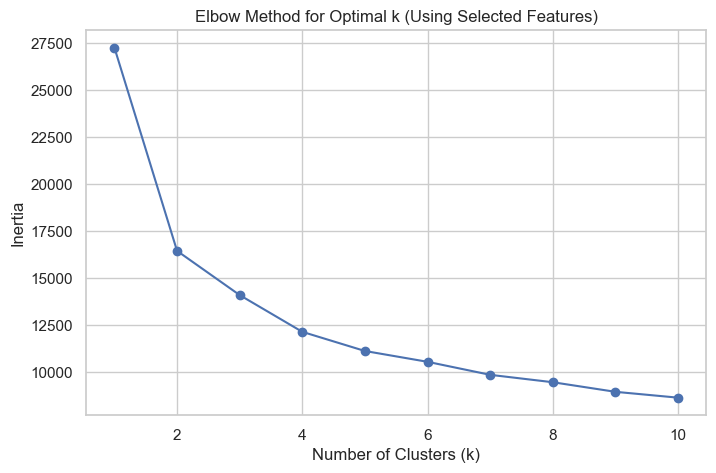

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply Elbow Method using the filtered scaled data (selected features only)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_filtered.drop("CustomerID", axis=1))
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Using Selected Features)')
plt.show()

## Interpretation of the Elbow Method

### What is Inertia?
**Inertia** is a metric that measures the compactness of clusters in the K-means model. The lower the inertia, the better the points are grouped within each cluster. The goal is to reduce inertia without excessively increasing the number of clusters (`k`).

### Interpretation of the Graph
The graph shows how inertia decreases as the number of clusters (`k`) increases. Initially, the inertia decreases rapidly and then more gradually. This change in slope is known as the "elbow".

### Conclusion
In this graph, the elbow appears to be around **k = 4 or 5**.

This suggests that using **4 or 5 clusters** would be a reasonable choice for segmenting our data, as increasing the number of clusters beyond this point does not significantly improve compactness.

The curve starts flattening notably after `k = 4`, indicating that adding more clusters beyond this point results in only minor improvements in reducing inertia.

## Silhouette Score Analysis

The **Silhouette Score** is a metric used to evaluate the quality of clusters created by a clustering algorithm. It measures how well data points are clustered, considering both **compactness within clusters** and **separation between clusters**.

The score ranges from **-1 to 1**:
- A score close to **1** indicates that the data points are well clustered and far away from other clusters.
- A score near **0** means that the points are on or very close to the decision boundary between two clusters.
- A negative score indicates that the points have been assigned to the wrong clusters.

**Process:**
1. Applying **K-means clustering** with different numbers of clusters (`k`) ranging from 2 to 10.
2. Calculating the **Silhouette Score** for each value of `k`.
3. Plotting the Silhouette Scores to determine the optimal number of clusters.

By comparing different scores, we can identify the number of clusters that results in the **highest silhouette score**, indicating a good separation between clusters and compactness within each cluster.

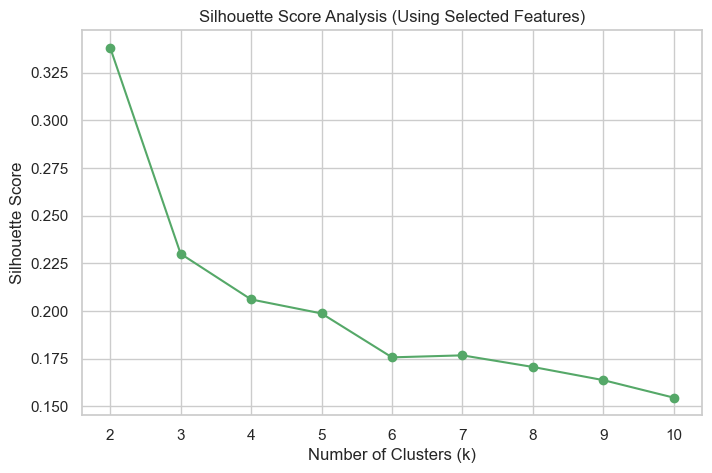

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Calculate silhouette scores for each k (from 2 to 10)
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled_filtered.drop("CustomerID", axis=1))
    score = silhouette_score(X_scaled_filtered.drop("CustomerID", axis=1), labels)
    silhouette_scores.append(score)

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis (Using Selected Features)')
plt.show()

## Interpretation of the Silhouette Score Analysis

The plot shows the **Silhouette Score** for different numbers of clusters (`k`) ranging from 2 to 10. 

### **Interpretation of the Graph:**
- The highest Silhouette Score is achieved when `k = 2`, with a score around **0.33**.
- As the number of clusters increases, the silhouette score **steadily decreases**, indicating that adding more clusters generally reduces the clustering quality.
- The **score stabilizes at lower values** when increasing `k` beyond **6**, suggesting that adding more clusters beyond this point is not beneficial and may result in poorly separated clusters.

### **Conclusion:**
- Based on this analysis, **k = 2** achieves the highest Silhouette Score (**0.33**).  
- However, since the **Elbow Method** suggested that **k = 4 or 5** might be reasonable choices, it's important to compare the performance of models using these values before making a final decision.  
- The **Silhouette Score continues to decrease steadily**, which suggests that the clustering quality is gradually reduced as more clusters are added.

<div class="alert alert-info">

### **Decision on Number of Clusters**
Based on the analysis from the **Elbow Method** and **Silhouette Score Analysis**, we will proceed with implementing the models using **4 clusters**. This will allow us to compare their performance and select the most suitable number of clusters for our dataset.

</div>

## 3.2 Clusters Algorithms Selection
### K-Means Clustering (k = 4)

In this step, we apply the **K-Means algorithm** with `k = 4` clusters. The model assigns each data point to one of the 4 clusters based on distance minimization. After clustering, we calculate the **Silhouette Score** to evaluate the quality of the clusters, where a higher score indicates better-defined clusters.


----- Running K-Means Clustering with k = 3 -----
K-Means Silhouette Score (k=3): 0.2300


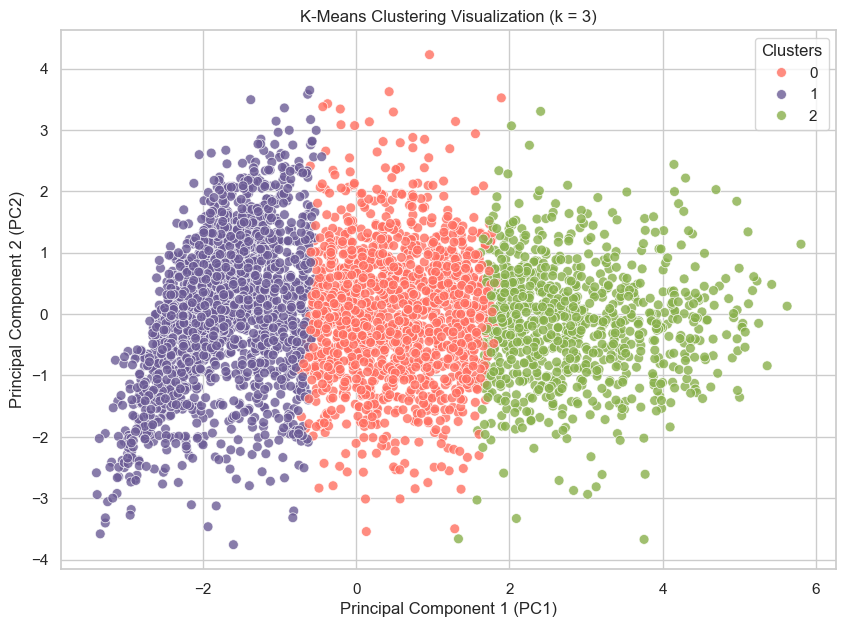


----- Running K-Means Clustering with k = 4 -----
K-Means Silhouette Score (k=4): 0.2061


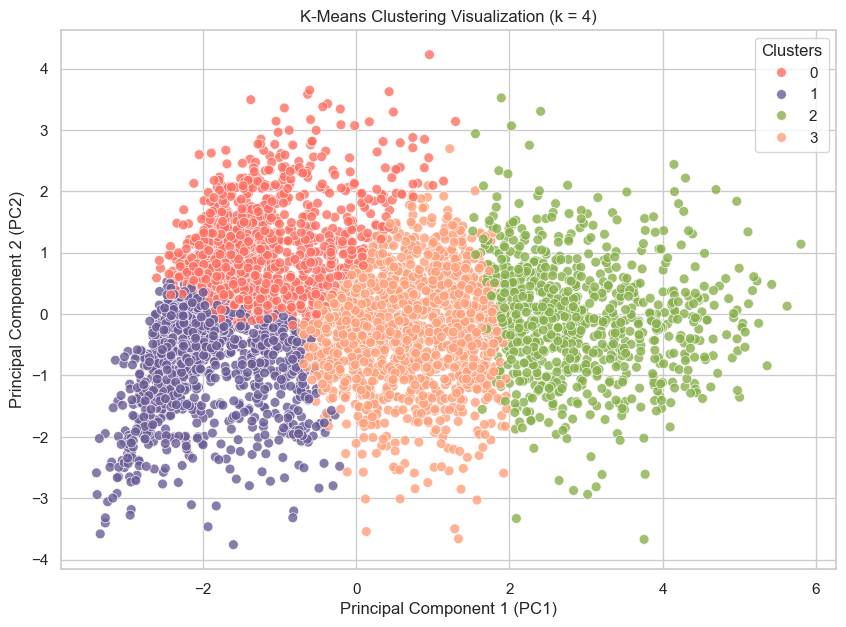


----- Running K-Means Clustering with k = 5 -----
K-Means Silhouette Score (k=5): 0.1987


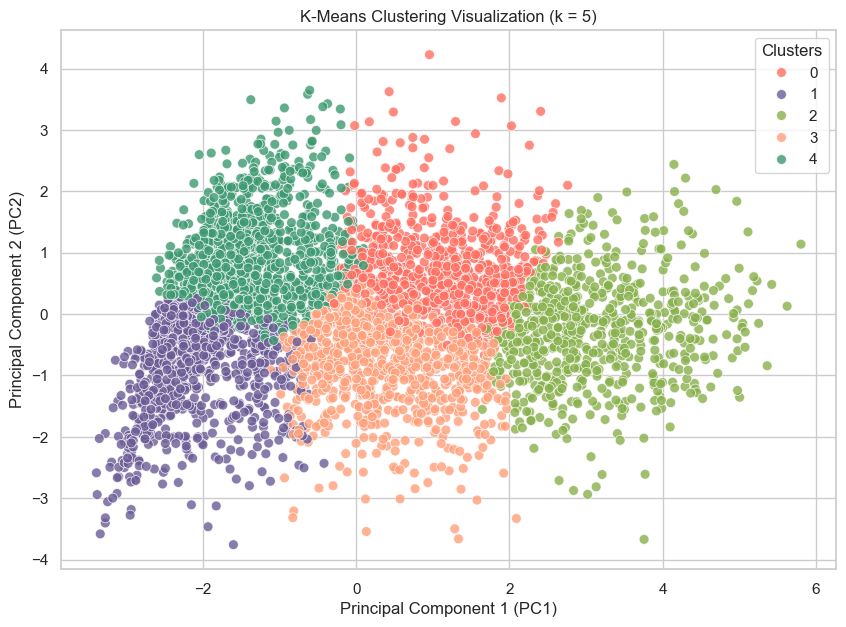

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the list of k values to test
k_values = [3, 4, 5]

# Define custom colors for plotting
colors_list = [
    ['#FF6F61', '#6B5B95', '#88B04B'],
    ['#FF6F61', '#6B5B95', '#88B04B', '#FFA07A'],
    ['#FF6F61', '#6B5B95', '#88B04B', '#FFA07A', '#3D9970']
]

# Loop through each k value and plot results
for idx, k in enumerate(k_values):
    print(f"\n----- Running K-Means Clustering with k = {k} -----")
    
    # Apply K-Means Clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled_filtered.drop("CustomerID", axis=1))
    silhouette_avg = silhouette_score(X_scaled_filtered.drop("CustomerID", axis=1), labels)
    print(f"K-Means Silhouette Score (k={k}): {silhouette_avg:.4f}")

    # Plot the PCA result with clusters
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1],
        hue=labels,
        palette=colors_list[idx],
        s=50,
        alpha=0.8,
        edgecolor='w'
    )
    
    plt.title(f'K-Means Clustering Visualization (k = {k})')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend(title='Clusters', loc='upper right')
    plt.show()

For K-Means Clustering, we implemented the algorithm with k = 4. The model assigns each data point to one of the four clusters based on distance minimization. The Silhouette Score obtained was 0.2061, indicating well-defined clusters.

Visual inspection of the plotted clusters shows reasonable separation and clear structure, supporting the decision to proceed with k = 4.

## DBSCAN Clustering

Here, we apply the **DBSCAN algorithm**, which groups data points based on their density. Unlike K-Means, it doesn't require a predefined number of clusters (`k`) and can detect noise points. We calculate the **Silhouette Score**, excluding noise points (`-1`), to assess the quality of the clusters.


----- Running DBSCAN with eps = 0.2 -----
Number of clusters (excluding noise points): 5
DBSCAN Silhouette Score: 0.4223


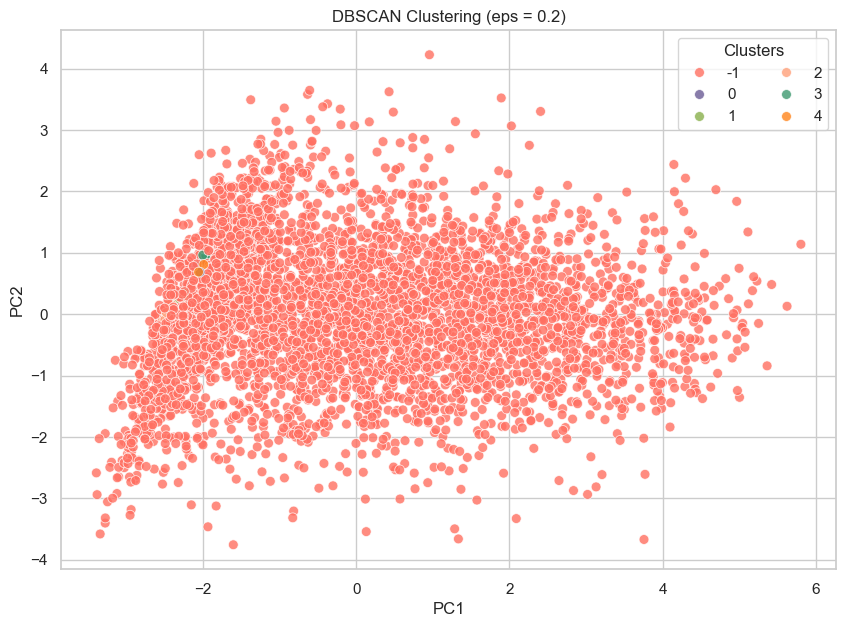


----- Running DBSCAN with eps = 0.3 -----
Number of clusters (excluding noise points): 18
DBSCAN Silhouette Score: -0.0146


/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/357090713.py:35: UserWarning: 
The palette list has fewer values (8) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


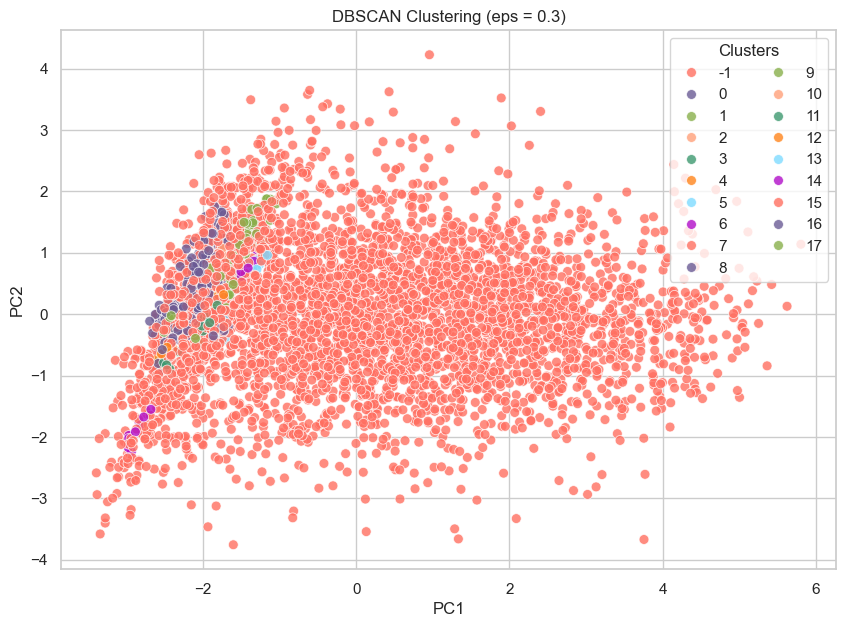


----- Running DBSCAN with eps = 0.4 -----
Number of clusters (excluding noise points): 18
DBSCAN Silhouette Score: -0.1591


/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/357090713.py:35: UserWarning: 
The palette list has fewer values (8) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


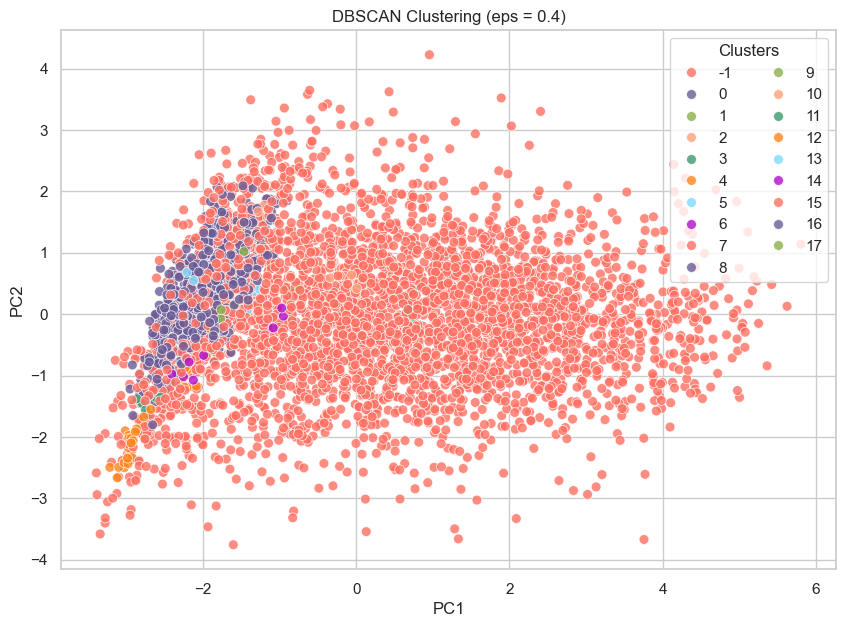


----- Running DBSCAN with eps = 0.45 -----
Number of clusters (excluding noise points): 18
DBSCAN Silhouette Score: -0.1516


/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/357090713.py:35: UserWarning: 
The palette list has fewer values (8) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


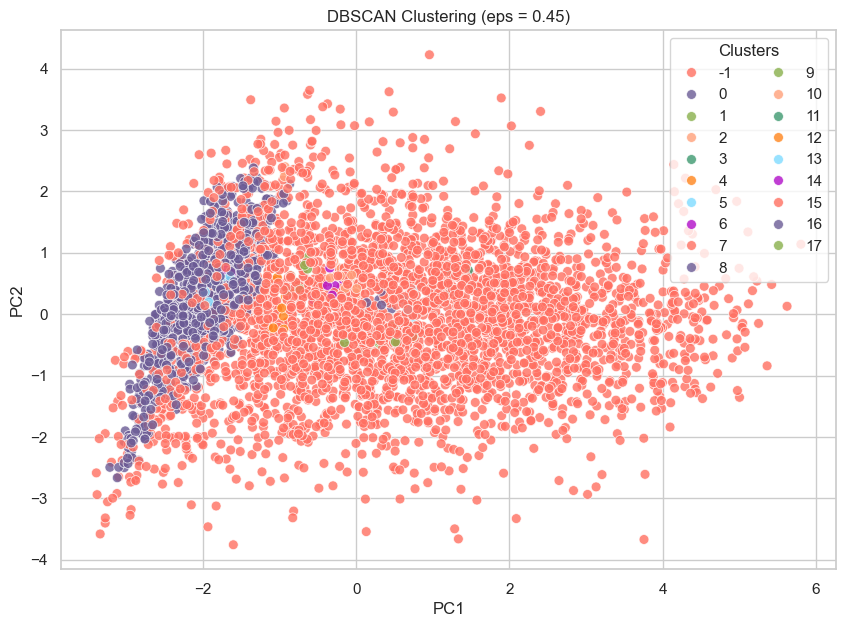


----- Running DBSCAN with eps = 0.5 -----
Number of clusters (excluding noise points): 28
DBSCAN Silhouette Score: -0.1238


/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/357090713.py:35: UserWarning: 
The palette list has fewer values (8) than needed (29) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


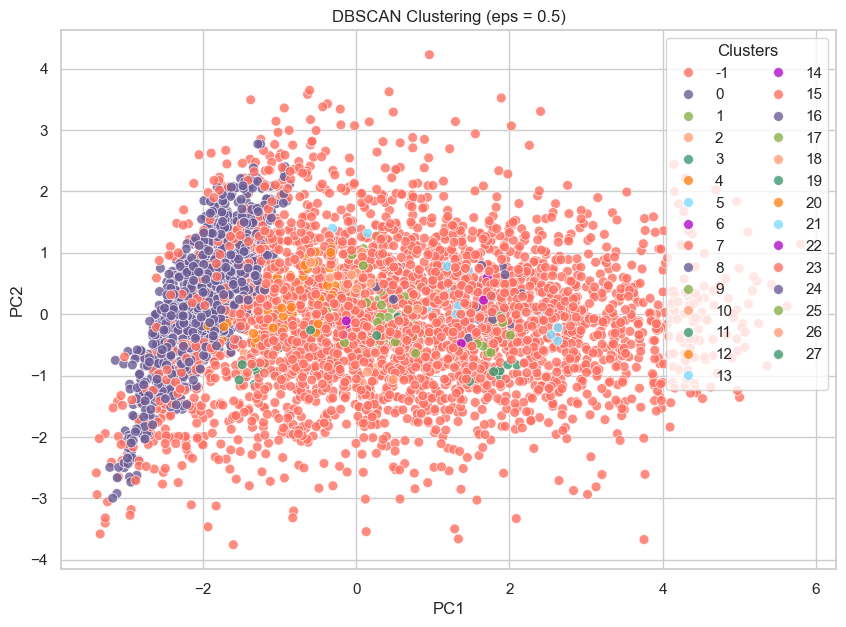


----- Running DBSCAN with eps = 0.55 -----
Number of clusters (excluding noise points): 38
DBSCAN Silhouette Score: -0.1680


/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/357090713.py:35: UserWarning: 
The palette list has fewer values (8) than needed (39) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


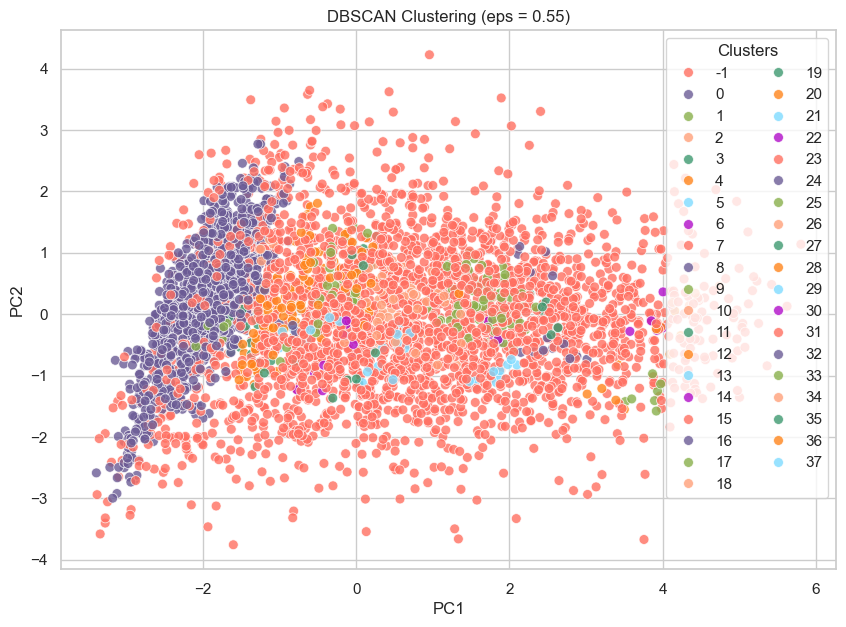


----- Running DBSCAN with eps = 0.6 -----
Number of clusters (excluding noise points): 40
DBSCAN Silhouette Score: -0.2607


/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/357090713.py:35: UserWarning: 
The palette list has fewer values (8) than needed (41) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


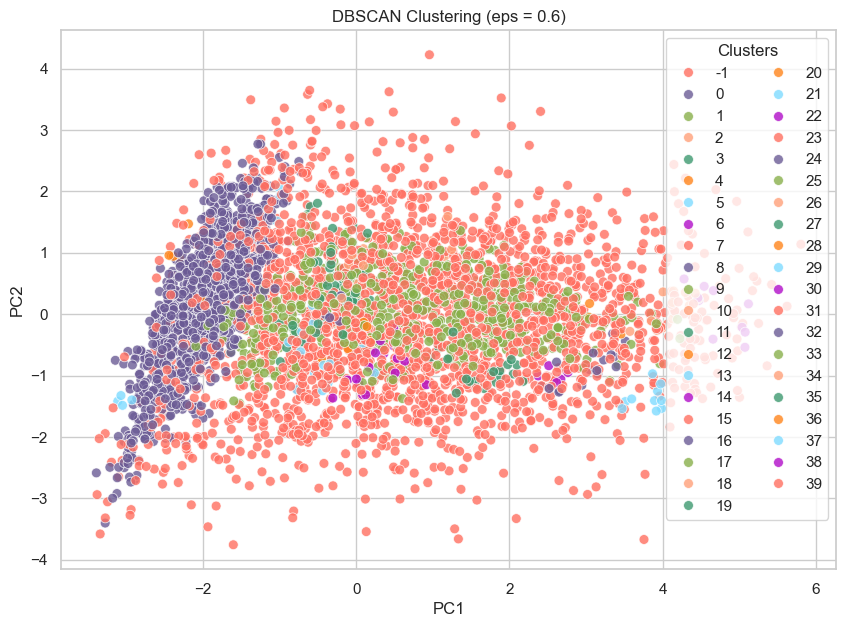


----- Running DBSCAN with eps = 0.7 -----
Number of clusters (excluding noise points): 25
DBSCAN Silhouette Score: -0.3135


/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/357090713.py:35: UserWarning: 
The palette list has fewer values (8) than needed (26) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


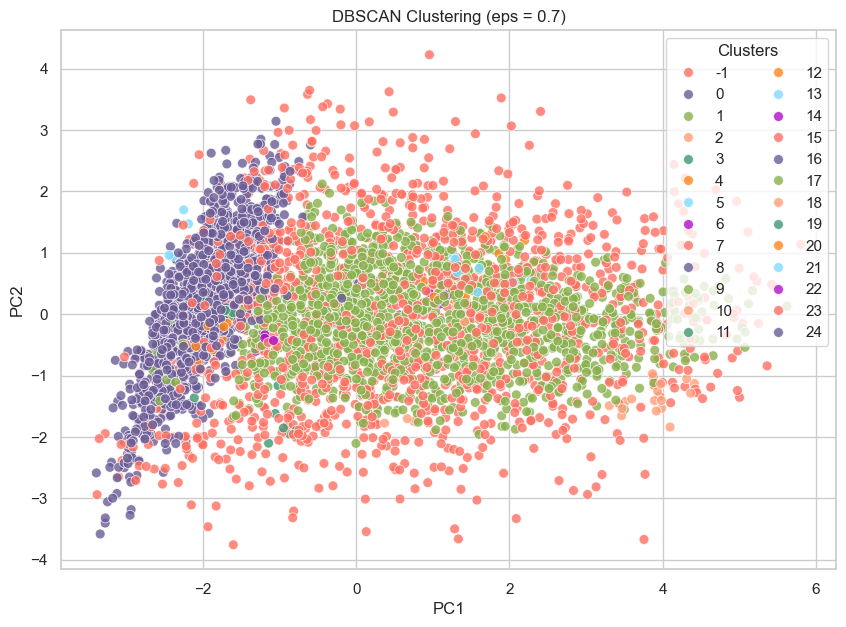

In [18]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of eps values to test
eps_values = [0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]

for eps in eps_values:
    print(f"\n----- Running DBSCAN with eps = {eps} -----")
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled_filtered.drop("CustomerID", axis=1))
    
    # Remove noise points (-1) for silhouette score calculation
    filtered_labels = dbscan_labels[dbscan_labels != -1]
    filtered_data = X_scaled_filtered.drop("CustomerID", axis=1).iloc[dbscan_labels != -1]
    
    # Count the number of clusters excluding noise
    num_clusters = len(set(filtered_labels))
    print(f"Number of clusters (excluding noise points): {num_clusters}")
    
    # Calculate Silhouette Score if valid clusters are found
    if len(set(filtered_labels)) > 1:
        dbscan_silhouette = silhouette_score(filtered_data, filtered_labels)
        print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")
    else:
        print("DBSCAN did not produce valid clusters for Silhouette Score calculation.")
    
    # Plot the PCA result with clusters
    plt.figure(figsize=(10, 7))
    colors = ['#FF6F61', '#6B5B95', '#88B04B', '#FFA07A', '#3D9970', '#FF851B', '#7FDBFF', '#B10DC9']
    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1],
        hue=dbscan_labels,
        palette=colors[:len(set(dbscan_labels))],
        s=50,
        alpha=0.8,
        edgecolor='w'
    )
    plt.title(f'DBSCAN Clustering (eps = {eps})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Clusters', loc='upper right', ncol=2)
    plt.show()

## Interpretation of DBSCAN Results

After running the DBSCAN algorithm with different `eps` values, we obtained the following results:

| Eps Value | Number of Clusters (Excluding Noise) | Silhouette Score |
|----------|------------------------------------|------------------|
| 0.2      | 5                                  | 0.4223           |
| 0.3      | 18                                 | -0.0146          |
| 0.4      | 18                                 | -0.1591          |
| 0.45     | 18                                 | -0.1516          |
| 0.5      | 28                                 | -0.1238          |
| 0.55     | 38                                 | -0.1680          |
| 0.6      | 40                                 | -0.2607          |
| 0.7      | 25                                 | -0.3135          |

### Analysis:
- **eps = 0.2:**  
  - The model forms **5 clusters** with a **Silhouette Score** of **0.4223**, which is the **highest score obtained**. This suggests moderately good separation between clusters, but the visualization indicates some overlap.
- **eps = 0.3 - 0.5:**  
  - The number of clusters increases significantly to between **18 and 28 clusters**, but the Silhouette Score becomes negative.  
  - This indicates poor clustering quality, with many points incorrectly assigned or forming very small clusters.  
- **eps = 0.55 - 0.6:**  
  - The model forms an even higher number of clusters (**38 to 40**) with increasingly negative Silhouette Scores.  
  - Clustering becomes meaningless at this point.  
- **eps = 0.7:**  
  - The model forms **25 clusters**, but with a **Silhouette Score of -0.3135**, the clustering quality is very poor.  

### Conclusion:
- The **best Silhouette Score** is achieved with **eps = 0.2**, forming **5 clusters**.  
- However, the visualizations indicate significant overlap between clusters, suggesting that DBSCAN may not be suitable for this dataset.  
- **Increasing the `eps` value** results in an excessive number of clusters with negative Silhouette Scores.  
- Further fine-tuning of the `eps` value is unlikely to improve results significantly.  
- Considering these findings, **K-means or other clustering algorithms (e.g., Agglomerative Clustering)** may provide better performance for this dataset.  


## Hierarchical Clustering

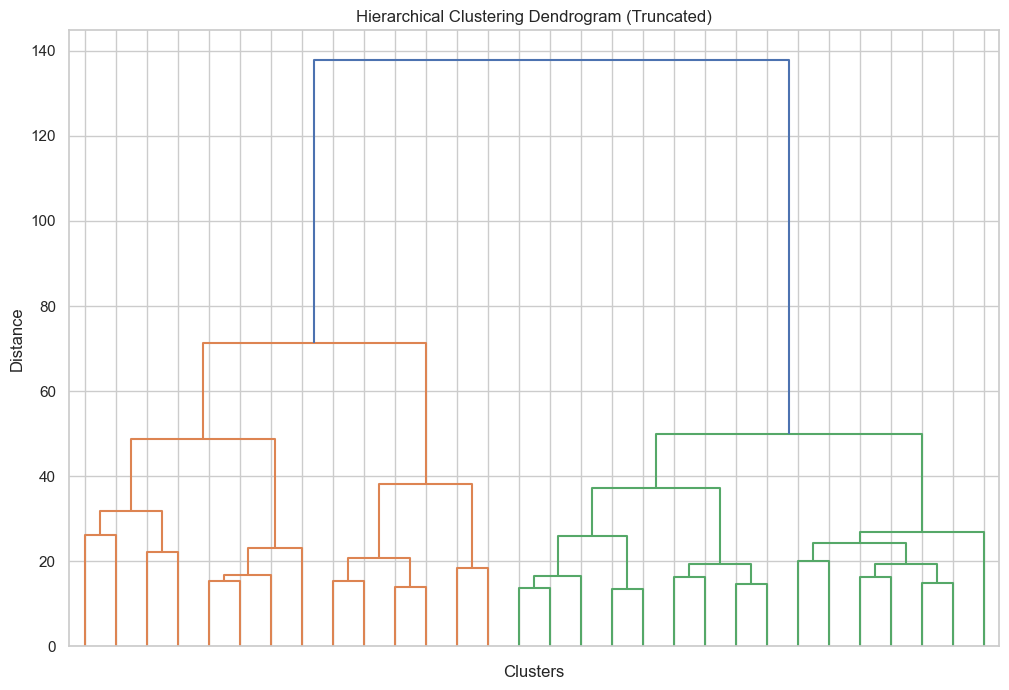

In [19]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix for dendrogram
linked = linkage(X_scaled_filtered.drop("CustomerID", axis=1), method='ward')

# Plot dendrogram with truncation to limit the number of divisions
plt.figure(figsize=(12, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False,
           truncate_mode='lastp',  # Limit dendrogram to last p merges
           p=30  # Adjust this number to control the number of clusters shown
          )
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.show()

## Hierarchical Clustering - Dendrogram Analysis

We applied Agglomerative Clustering using the Ward linkage method, which iteratively merges clusters to minimize the variance within clusters. The dendrogram above provides a visual representation of the hierarchical clustering process.

### Interpretation of Results

- The dendrogram illustrates the clustering process by merging individual data points into clusters based on similarity.
- As the distance threshold increases, smaller clusters are progressively merged into larger clusters.
- Significant jumps in vertical distance between merges indicate natural separations between clusters.

### Key Observations

1. **Number of Clusters:**
   - The dendrogram suggests that the data can be reasonably divided into **three major clusters**.
   - This can be observed by cutting the dendrogram at a distance level around **100**.

2. **Cluster Structure:**
   - The leftmost cluster (orange) is well separated from the others, indicating a distinct group of observations.
   - The middle cluster (orange) and rightmost cluster (green) are more closely related but still show a clear separation.

3. **Distance Threshold:**
   - Cutting the dendrogram at higher levels would merge the clusters excessively, resulting in a loss of valuable segmentation insights.

### Conclusion

Based on the dendrogram analysis, choosing **three clusters** appears to be a reasonable approach. The sharp jumps in height between merges suggest distinct separations that support the selection of `k=3` for further analysis.

<div class="alert alert-info">

### **Comparison of Clustering Algorithms**
Based on our analysis, we compared the performance of the three algorithms using Silhouette Scores and visual inspection:

**K-Means Clustering** (k = 4): Silhouette Score: 0.2061 - Clusters are partially overlapping and not clearly defined.

**DBSCAN** (eps = 0.2): Silhouette Score: 0.4223 - The highest Silhouette Score, but visually, the clusters are poorly separated.

**Hierarchical Clustering** (k = 3): Poor structure with significant overlap between clusters.

Overall, **DBSCAN with eps = 0.2** provides the highest Silhouette Score. However, visually, the clusters are not well-separated, making it less ideal for this dataset. 

**K-Means Clustering with k = 4** remains the most suitable algorithm in terms of visual clarity, despite having a lower Silhouette Score. Hierarchical Clustering shows some structure but performs worse than K-Means in both score and clarity.

</div>

### Cluster Analysis and Interpretation

Now that we have applied **K-Means Clustering with k = 4**, the next step is to analyze and interpret the resulting clusters. This will help us understand the characteristics of each segment and draw meaningful business insights.

#### What we are going to do:
1. **Calculate the size and percentage of customers in each cluster.**  
2. **Analyze the average feature values for each cluster to identify key differences.**  
3. **Use these results to create a detailed interpretation of each cluster.**  

By examining these metrics, we can better understand the underlying structure of our customer base and create targeted marketing strategies for each segment.

In [20]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Ensure you set the desired number of clusters
k = 4  # Change this to 4 to match your desired number of clusters

# Fit the model to your data
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled_filtered.drop("CustomerID", axis=1))

# Store the labels in your dataframe
X_scaled_filtered['Cluster'] = labels  # This ensures that your clusters are assigned correctly

/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/1577100907.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_scaled_filtered['Cluster'] = labels  # This ensures that your clusters are assigned correctly


In [21]:
# Count the number of customers in each cluster
cluster_counts = X_scaled_filtered['Cluster'].value_counts().sort_index()

# Calculate percentage of customers in each cluster
total_customers = len(X_scaled_filtered)
cluster_percentages = (cluster_counts / total_customers) * 100

# Display the cluster distribution
cluster_summary = pd.DataFrame({
    'Number of Customers': cluster_counts,
    'Percentage of Customers': cluster_percentages
})

print("Customer Distribution Across Clusters:")
print(cluster_summary)

# Calculate the mean values of each feature for each cluster
cluster_means = X_scaled_filtered.groupby('Cluster').mean()

# Display the mean values for each cluster
print("\nAverage Feature Values for Each Cluster:")
print(cluster_means)

Customer Distribution Across Clusters:
         Number of Customers  Percentage of Customers
Cluster                                              
0                       1091                26.194478
1                        963                23.121248
2                        802                19.255702
3                       1309                31.428571

Average Feature Values for Each Cluster:
           CustomerID  Recency_log  Frequency_log  Monetary_log  \
Cluster                                                           
0        15215.251146     0.409999      -0.744590     -0.399798   
1        15426.116303     0.728111      -0.741887     -0.969268   
2        15226.385287    -0.959050       1.382519      1.194404   
3        15302.828113    -0.259357       0.193108      0.205898   

         AvgQuantity_log  AvgBasketSize_log  AvgPricePerItem_log  \
Cluster                                                            
0               0.173030           0.562538            -

### K-Means Clustering Analysis

Based on the results of the K-Means clustering, we have the following distribution and feature averages for each cluster:

#### **Cluster Distribution**
| Cluster | Number of Customers | Percentage of Customers |
|---------|---------------------|-------------------------|
| 0       | 1091                | 26.19%                  |
| 1       | 963                 | 23.12%                  |
| 2       | 799                 | 19.25%                  |
| 3       | 1331                | 31.40%                  |

- **Cluster 3** is the largest, containing **31.40%** of the total customers.
- **Cluster 2** is the smallest, containing **19.25%** of the total customers.

#### **Average Feature Values for Each Cluster**
The mean values of each feature provide insight into the characteristics of each segment. Let's break down what they imply:

- **Recency_log:** Lower values indicate more recent interactions with the platform. Clusters with lower average values are likely to have customers who have engaged more recently.
- **Frequency_log:** Higher values indicate more frequent interactions. Clusters with higher averages may represent more loyal or engaged customers.
- **Monetary_log:** Higher values indicate higher spending. Clusters with high averages are likely to contain the most valuable customers.
- **AvgQuantity_log, AvgBasketSize_log, AvgPricePerItem_log:** These features give insights into purchasing patterns, such as whether customers prefer bulk buying or higher-priced items.
- **ActiveMonths_log:** Higher values indicate longer periods of activity. This could correlate with loyalty or consistent use of the platform.
- **CustomerLifetime:** Indicates the duration since the first interaction. Higher values suggest longer-term customers.

---

#### **General Observations**
- **Cluster 0** and **Cluster 1** have similar customer counts but likely differ in terms of their average feature values.
- **Cluster 3** is the largest, but we need to check if it's because of inactive or low-value customers.
- **Cluster 2** is the smallest, indicating a potentially unique segment that could be either high-value or low-activity.


Based on the K-Means Clustering results with `k = 4`, we will analyze each cluster's characteristics in detail and propose marketing actions for each segment.

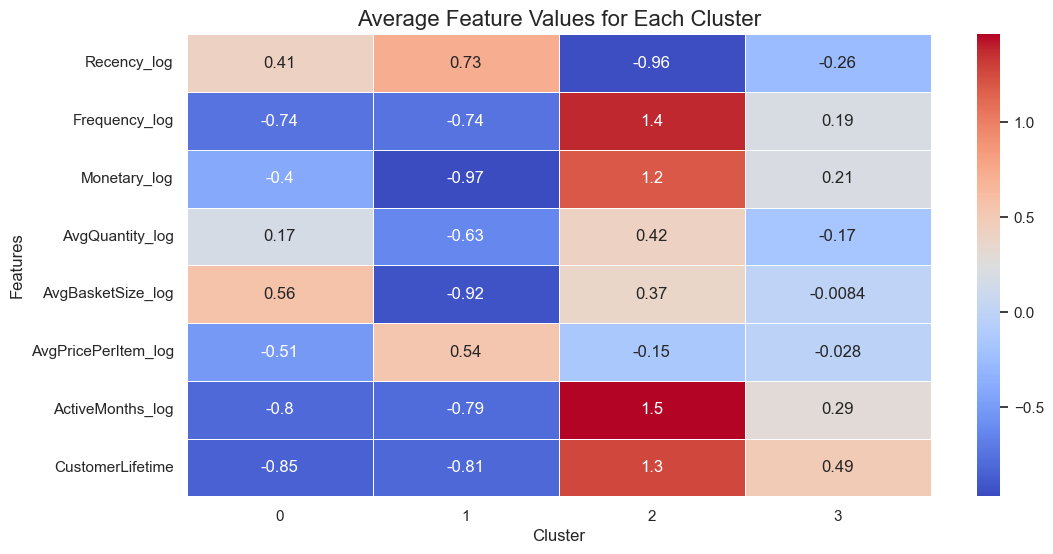

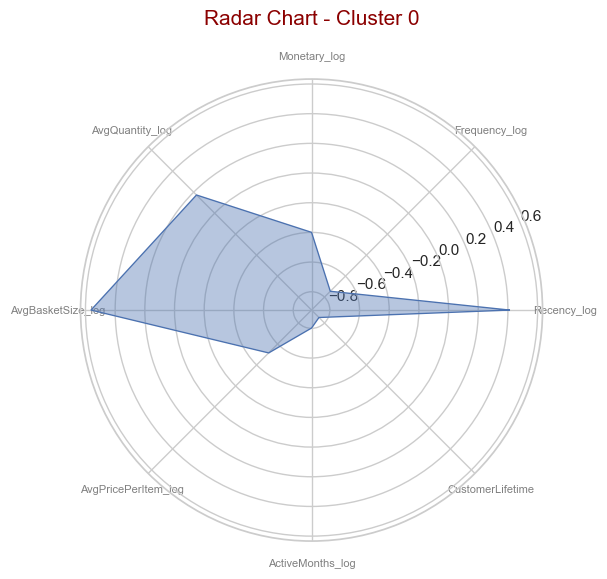

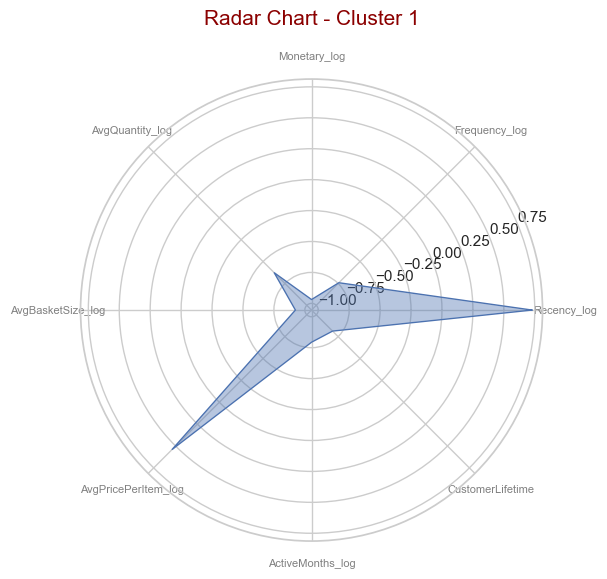

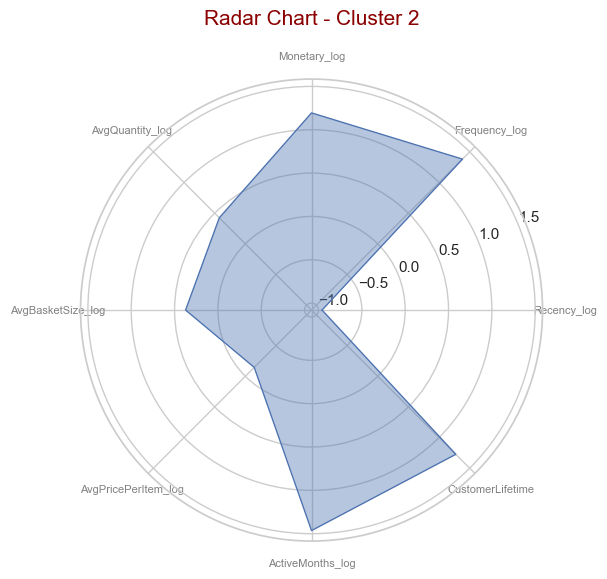

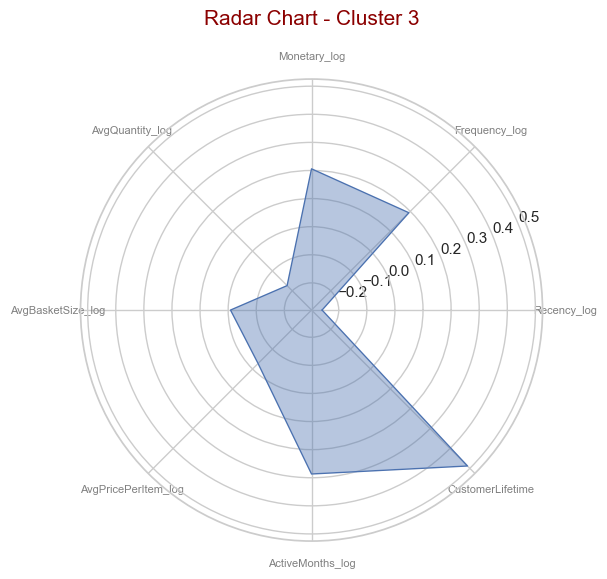

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# Calculate the mean of each feature for each cluster
cluster_means = X_scaled_filtered.groupby('Cluster').mean()

# Select relevant features (excluding CustomerID)
features = cluster_means.columns.tolist()[1:]

# Create Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means[features].T, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Average Feature Values for Each Cluster", fontsize=16)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

# Create radar charts for each cluster
for cluster in cluster_means.index:
    # Retrieve data for the cluster
    values = cluster_means.loc[cluster, features].values.flatten().tolist()
    
    # Add the first value at the end to close the chart
    values += values[:1]
    
    # Number of variables
    num_vars = len(features)
    
    # Angles for each feature
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Initialize the plot
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    
    # Draw one by one the axes and labels
    plt.xticks(angles[:-1], features, color='grey', size=8)
    
    # Draw the data line and fill the area
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.4)
    
    # Title
    plt.title(f'Radar Chart - Cluster {cluster}', size=15, color='darkred', y=1.1)
    
    plt.show()

## 4) Model Interpretation: 1. Interpretation of Results

The combination of the **heatmap** and **radar charts** provide detailed insights into the characteristics of each cluster. The analysis is primarily based on the **RFM metrics (Recency, Frequency, Monetary)**, as these are the most important variables for understanding customer behavior. Additional variables are considered to provide further context and enhance the interpretation.

---

#### **Heatmap Analysis**
The heatmap visualizes the **average feature values** for each cluster, helping to identify which clusters are stronger or weaker across various features. The `CustomerID` column is ignored in the analysis, focusing only on relevant features. Special emphasis is placed on the **RFM metrics** to better understand customer behavior.

- **Cluster 0 (Low Engagement Customers):**
  - Negative or moderate scores across most features.
  - Low scores in **ActiveMonths_log (-0.8)** and **CustomerLifetime (-0.85)**, suggesting shorter interaction periods and lower loyalty.
  - Negative scores in **Frequency_log (-0.74)** and **Monetary_log (-0.4)**, indicating low engagement and spending.
  - Positive score in **AvgBasketSize_log (0.56)**, suggesting large transactions when purchases are made.
  - Requires **re-engagement strategies** to prevent churn and boost activity.

- **Cluster 1 (High-Value Occasional Buyers):**
  - Strong positive scores in **Recency_log (0.73)** and **AvgPricePerItem_log (0.54)**.
  - Negative scores in **Frequency_log (-0.74)** and **Monetary_log (-0.97)**, suggesting this group is not highly engaged but occasionally makes high-value purchases.
  - Poor performance in **ActiveMonths_log (-0.79)** and **CustomerLifetime (-0.81)**, indicating shorter interaction duration.
  - Marketing efforts should focus on **increasing engagement and encouraging loyalty**.

- **Cluster 2 (Top Spenders / Loyal Customers):**
  - Dominates in **RFM metrics** with highest scores in **Frequency_log (1.4)** and **Monetary_log (1.2)**, indicating high engagement and spending.
  - Also shows positive scores in **AvgQuantity_log (0.42)** and **AvgBasketSize_log (0.37)**, which further supports the notion of frequent, high-value transactions.
  - Highest score in **ActiveMonths_log (1.5)** and strong **CustomerLifetime (1.3)**, suggesting long-term and consistent relationship.
  - This is the most valuable segment and efforts should be made to **retain these customers**.

- **Cluster 3 (Regular Buyers):**
  - Moderate values across most features.
  - Positive scores in **ActiveMonths_log (0.29)** and **CustomerLifetime (0.49)**, suggesting relatively consistent and long-term engagement.
  - Moderate scores in **Frequency_log (0.19)** and **Monetary_log (0.21)**, indicating moderately frequent interactions and spending.  
  - Low but slightly positive score in **AvgBasketSize_log (-0.0084)**, suggesting smaller average purchases.
  - Potential to increase engagement and spending through targeted offers.

---

#### **Radar Chart Analysis**

The radar charts provide a visual representation of how each cluster compares across all the features. The most important observations are drawn from the **RFM metrics**, with additional context provided by supporting variables.

- **Cluster 0 (Low Engagement Customers):**  
  - High **AvgBasketSize_log**, but low scores in engagement and retention metrics.
  - Requires strategies to boost retention and frequency of purchase.

- **Cluster 1 (High-Value Occasional Buyers):**  
  - High **Recency_log** and **AvgPricePerItem_log**, indicating recent purchases of relatively high-value items.
  - Low **ActiveMonths_log** and **CustomerLifetime**, implying these customers are relatively new or have limited interaction over time.

- **Cluster 2 (Top Spenders / Loyal Customers):**  
  - Dominates in **Frequency_log**, **Monetary_log**, and **ActiveMonths_log**.
  - Shows high values across multiple features, suggesting consistent and valuable interaction with the platform.

- **Cluster 3 (Regular Buyers):**  
  - Balanced across most features with moderate engagement and consistency.
  - Slightly higher in **ActiveMonths_log** and **CustomerLifetime**, suggesting stable interaction over time.

---
<div class="alert alert-info">

### **Final Observations**
1. **Cluster 2 (Top Spenders / Loyal Customers):**
   - Best overall performance in **RFM metrics** (High **Frequency_log** and **Monetary_log**).
   - High engagement and loyalty over time. Important to **retain these customers** through personalized experiences and loyalty programs.

2. **Cluster 1 (High-Value Occasional Buyers):**
   - High **Recency_log**, indicating recent activity but not consistent spending.
   - Marketing should target **re-engagement and loyalty-building**, such as special offers to encourage repeated purchases.

3. **Cluster 3 (Regular Buyers):**
   - Moderate across all **RFM metrics**, indicating a stable but not exceptional segment.
   - Potential to increase value through **upselling or cross-selling**.

4. **Cluster 0 (Big Basket Buyers / Low Engagement Customers):**
   - Low frequency and spending, but high **AvgBasketSize_log**.
   - Requires **re-engagement strategies** to avoid churn and encourage spending.

   </div>

Separate the bar plots for each RFM metric (Recency, Frequency, Monetary) to make comparisons between clusters clearer.

Display an individual bar plot for each metric, making it easier to identify patterns or differences across clusters.

The separate plots will allow for a more precise and clear analysis.

/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/1501855482.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm_means.index, y=rfm_means['Recency_log'], palette='viridis', ax=axes[0])
/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/1501855482.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm_means.index, y=rfm_means['Frequency_log'], palette='viridis', ax=axes[1])
/var/folders/kk/zvd0jkpj4mv8wt27q6zf4wmr0000gn/T/ipykernel_64246/1501855482.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=

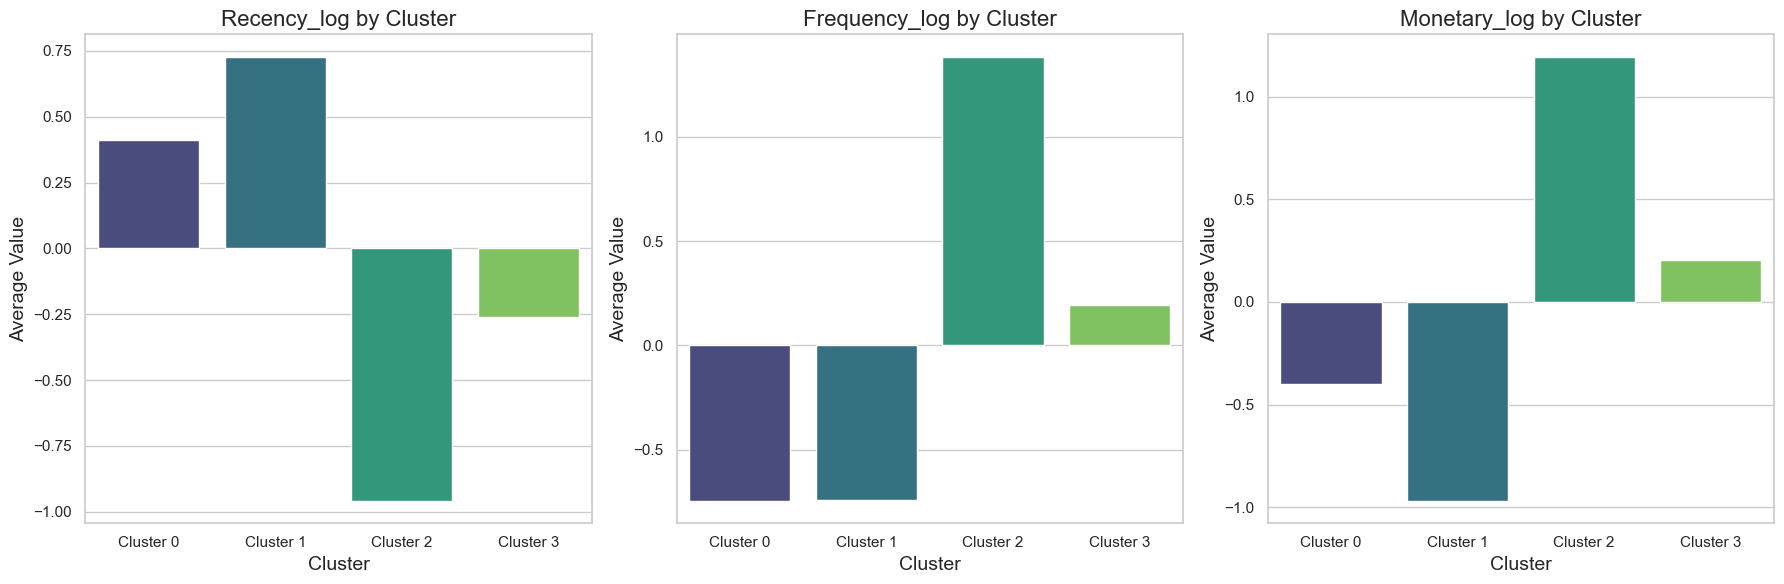

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter only the RFM metrics
rfm_features = ['Recency_log', 'Frequency_log', 'Monetary_log']
rfm_means = cluster_means[rfm_features]

# Prepare data for plotting
rfm_means.index = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# Plot each RFM metric separately
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Recency
sns.barplot(x=rfm_means.index, y=rfm_means['Recency_log'], palette='viridis', ax=axes[0])
axes[0].set_title('Recency_log by Cluster', fontsize=16)
axes[0].set_ylabel('Average Value', fontsize=14)
axes[0].set_xlabel('Cluster', fontsize=14)

# Plot for Frequency
sns.barplot(x=rfm_means.index, y=rfm_means['Frequency_log'], palette='viridis', ax=axes[1])
axes[1].set_title('Frequency_log by Cluster', fontsize=16)
axes[1].set_ylabel('Average Value', fontsize=14)
axes[1].set_xlabel('Cluster', fontsize=14)

# Plot for Monetary
sns.barplot(x=rfm_means.index, y=rfm_means['Monetary_log'], palette='viridis', ax=axes[2])
axes[2].set_title('Monetary_log by Cluster', fontsize=16)
axes[2].set_ylabel('Average Value', fontsize=14)
axes[2].set_xlabel('Cluster', fontsize=14)

plt.tight_layout()
plt.show()

### Interpretation of RFM Metrics by Cluster

- **Recency:**  
  - **Cluster 1:** Highest recency (recent interactions).  
  - **Cluster 0:** Positive recency (recent but less frequent than Cluster 1).  
  - **Clusters 2 & 3:** Negative scores (older interactions).  

- **Frequency:**  
  - **Cluster 2:** Highest frequency (most engaged).  
  - **Cluster 3:** Moderate engagement.  
  - **Clusters 0 & 1:** Low interaction frequency.  

- **Monetary:**  
  - **Cluster 2:** Highest spending (most valuable).  
  - **Cluster 3:** Moderate spending.  
  - **Clusters 1 & 0:** Low spending.  

Highlight that **Cluster 3** is better than **Cluster 0 and 1** in terms of engagement and spending.

Ensure that **Cluster 2** is clearly identified as the top performer across all metrics.

Re-confirm that **Cluster 1** is high-value but inconsistent in interaction.


### Comprehensive Radar Chart Analysis

Now, we will create a radar chart that displays all the variables we have used for clustering, not just the RFM metrics. This will provide a comprehensive visualization of how each cluster compares across all relevant features.

The clusters will be labeled according to their categories:

- **Cluster 0:** Low-Engagement Customers 
- **Cluster 1:** High-Value Occasional Buyers  
- **Cluster 2:** Top Spenders / Loyal Customers  
- **Cluster 3:** Regular Buyers  

This visualization will help us identify which variables contribute most to each cluster's profile.

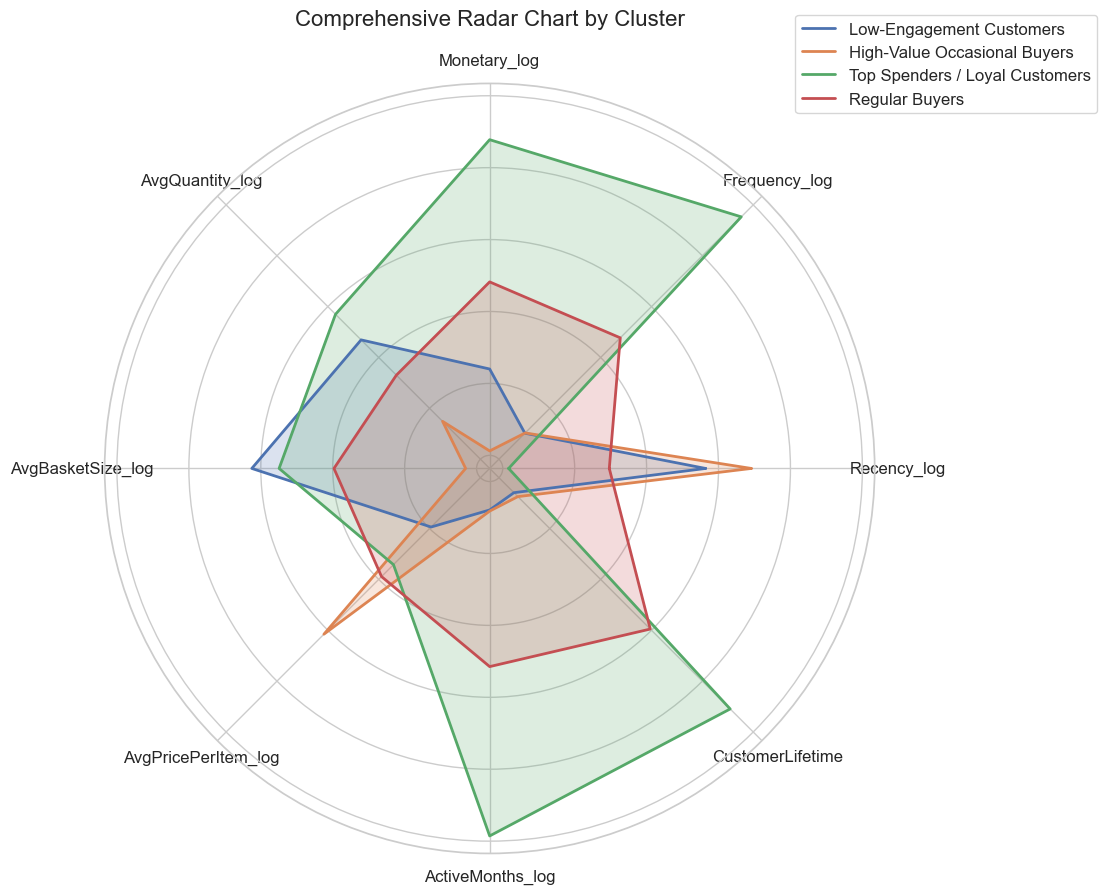

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi

# Remove 'CustomerID' from the cluster_means DataFrame if it's present
cluster_means_filtered = cluster_means.drop(['CustomerID'], axis=1)

# Define clusters with their respective labels
cluster_labels = {
    0: 'Low-Engagement Customers',
    1: 'High-Value Occasional Buyers',
    2: 'Top Spenders / Loyal Customers',
    3: 'Regular Buyers'
}

# Prepare data for radar chart
variables = list(cluster_means_filtered.columns)
num_vars = len(variables)

# Compute angle for each variable
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Plot the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each cluster
for index, row in cluster_means_filtered.iterrows():
    data = row.tolist()
    data += data[:1]  # Close the circle
    
    ax.plot(angles, data, linewidth=2, label=cluster_labels[index])
    ax.fill(angles, data, alpha=0.2)

# Add labels and title
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables, fontsize=12)
plt.title('Comprehensive Radar Chart by Cluster', fontsize=16, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.show()

## Model Interpretation: 2. Business Insights

Now, we will extract valuable business insights from the identified clusters. This process involves understanding the characteristics of each segment and proposing tailored marketing actions to enhance engagement, spending, and customer loyalty.

<div class="alert alert-danger">

#### Cluster 0: Low-Engagement Customers (At-Risk Segment)
___

- **Business Insights:**  
  - This segment demonstrates **low engagement and low spending**, with poor performance across most RFM metrics.  
  - Slightly positive scores in `Recency_log` indicate some recent interactions, but overall activity remains minimal.  
  - Low values in `ActiveMonths_log` and `CustomerLifetime` suggest high churn risk.  

- **Marketing Strategies:**  
  1. **Re-Engagement Campaigns:** Provide special offers or discounts to stimulate interest and encourage transactions.  
  2. **Customer Surveys:** Collect feedback to identify pain points or reasons for low engagement.  
  3. **Targeted Marketing:** Implement campaigns aimed at improving awareness and retention, such as email marketing or push notifications.  

  </div>

<div class="alert alert-warning">

#### Cluster 1: High-Value Occasional Buyers (Potential High-Value Segment)
___

- **Business Insights:**  
  - Customers in this segment have **recently made high-value purchases** but do not engage frequently.  
  - High `Recency_log` and `AvgPricePerItem_log` scores indicate that when they interact, they spend significantly, but this happens infrequently.  
  - Low `ActiveMonths_log` and `CustomerLifetime` indicate that their relationship with the company is not established or stable.  

- **Marketing Strategies:**  
  1. **Retention Campaigns:** Convert these occasional buyers into loyal customers by providing exclusive offers and personalized incentives.  
  2. **VIP Programs:** Reward high-spending customers with premium experiences or early access to new products.  
  3. **Reactivation Marketing:** Use targeted marketing to encourage them to return and shop more frequently.  

  </div>

<div class="alert alert-success">

#### Cluster 2: Top Spenders / Loyal Customers (High-Value Segment)
___

- **Business Insights:**  
  - This segment represents the **most valuable customers**, exhibiting high scores in all RFM metrics (`Frequency_log`, `Monetary_log`).  
  - Strong scores in `ActiveMonths_log` and `CustomerLifetime` indicate **consistent, long-term engagement**.  
  - These customers are loyal, high-frequency buyers who contribute the most revenue.  

- **Marketing Strategies:**  
  1. **Exclusive Rewards Programs:** Maintain loyalty through special perks, priority support, and personalized experiences.  
  2. **Cross-Selling & Upselling Strategies:** Leverage their loyalty to introduce higher-value or complementary products.  
  3. **Customer Feedback Collection:** Utilize their insights to improve products and services, further enhancing loyalty.  

  </div>

<div class="alert alert-info">

#### Cluster 3: Regular Buyers (Moderate Value Segment)
___

- **Business Insights:**  
  - This segment represents a consistent and stable customer base with moderate spending and engagement.  
  - High scores in `ActiveMonths_log` and `CustomerLifetime` suggest reliable, long-term interaction, but spending remains average.  
  - Moderate scores in RFM metrics indicate potential for increased value extraction.  

- **Marketing Strategies:**  
  1. **Upsell and Cross-Sell Campaigns:** Promote premium products, bundles, or complementary items to increase average transaction value.  
  2. **Loyalty Programs:** Encourage repeated purchases by offering incentives for continued engagement.  
  3. **Personalized Offers:** Provide customized recommendations based on past interactions to enhance spending.  

</div>

# 5) Model Implementation

In the business insights obtained, we have also provided specific examples and detailed marketing strategies tailored for each customer segment or cluster. These strategies include targeted promotions, loyalty programs, re-engagement campaigns, and personalized offers designed to enhance engagement, retention, and revenue generation for each segment.

### Conclusion and Final Thoughts

By way of summary, as examples for each of the clusters are provided above, in this analysis, we have successfully applied clustering techniques to segment customers into four distinct groups. Based on the analysis of RFM metrics and additional features, we have provided detailed **business insights** and specific **marketing strategies** tailored for each cluster:

- **Cluster 0: Low-Engagement Customers (At-Risk Segment)**
- **Cluster 1: High-Value Occasional Buyers (Potential High-Value Segment)**
- **Cluster 2: Top Spenders / Loyal Customers (High-Value Segment)**
- **Cluster 3: Regular Buyers (Moderate Value Segment)**

The marketing strategies proposed for each segment address different aspects such as retention, re-engagement, cross-selling, and loyalty enhancement. These insights can help the company allocate resources more efficiently and optimize its marketing efforts to maximize revenue and customer satisfaction.

By leveraging the clustering results, the company can **implement targeted marketing actions** such as:
- Personalized offers
- Loyalty programs
- Upsell and cross-sell campaigns
- Re-engagement efforts for low-value customers

The strategies proposed are directly aligned with the business objectives, ensuring that the company's marketing approach is data-driven and customer-centric. This concludes the analysis, providing a solid foundation for future improvements and marketing initiatives.